In [1]:
library(Seurat)
library(tidyverse)
library(patchwork)
library(glue)
set.seed(42)

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.5.1 but the current version is
4.5.2; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
pbmc.data <- Read10X("/projects/mipt_dbmp_biotechnology/single_cell/H068_sample_filtered_feature_bc_matrix")

pbmc <- CreateSeuratObject(
  counts = pbmc.data[["Gene Expression"]],
  project = "pbmc3k",
  min.cells = 3,
  min.features = 200
)

pbmc

10X data contains more than one type and is being returned as a list containing matrices of each type.



An object of class Seurat 
22584 features across 8633 samples within 1 assay 
Active assay: RNA (22584 features, 0 variable features)
 1 layer present: counts

*О каком количестве клеток и генов содержится информация в .mtx файле? Опишите в общих словах, каким образом CellRanger фильтрует “плохие” клетки.*  
В загруженной матрице Gene Expression содержится информация о 22 584 генах (число строк матрицы), 8 633 клетках (число столбцов матрицы).  
Работа CellRanger: берет библиотеку из FASTQ файлов -> выравнивает на референс -> из полученного BAM-файла получаем каунты подсчетом числа уникальных молекул (благодаря UMI) -> строится матрица: строки - гены; столбцы - клетки


*Что фильтруется при создании Seurat-объекта (min.cells = 3, min.features = 200)? Сколько клеток и генов проходит данную фильтрацию?*  
Происходит первичная фильтрация: min.cells = 3 — удаляются гены, которые экспрессируются меньше чем в 3 клетках (может быть шумом); min.features = 200 — удаляются клетки, в которых опознано меньше 200 генов (пустые капли или технический шум). В нашем случе такую фильтрацию прошли 8633 клетки и 22584 гена

In [3]:
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

In [4]:
head(pbmc@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACCTGAGATGTCGG-1,pbmc3k,3366,1576,2.198455
AAACCTGAGCAACGGT-1,pbmc3k,8119,3196,1.638133
AAACCTGAGCTCAACT-1,pbmc3k,4419,2115,2.919212
AAACCTGAGGGCATGT-1,pbmc3k,584,336,37.842466
AAACCTGAGTTATCGC-1,pbmc3k,915,566,12.349727


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


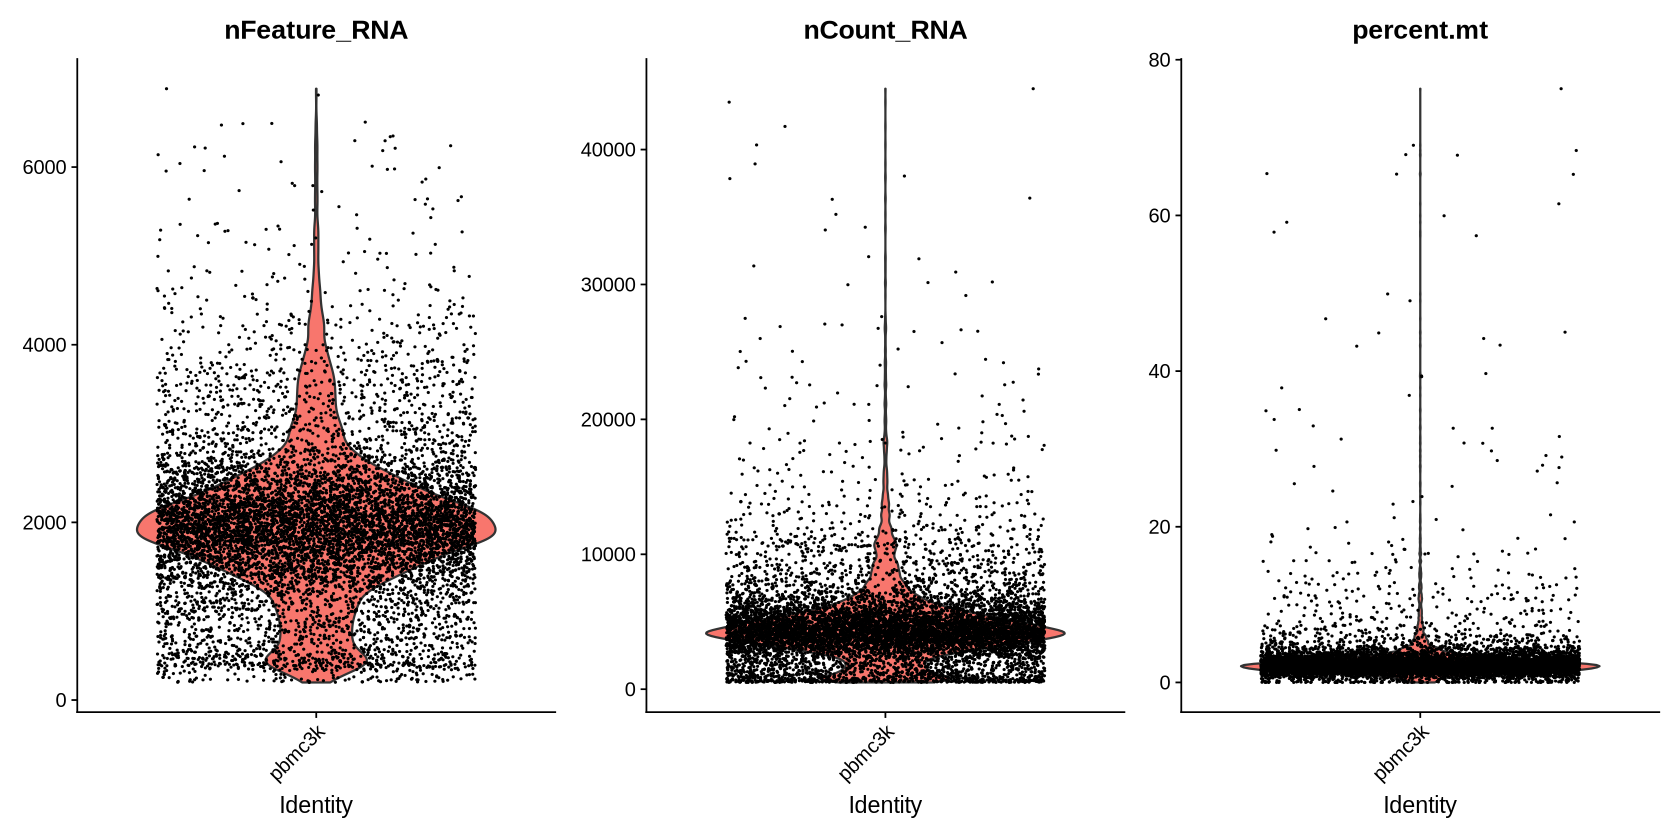

In [5]:
options(repr.plot.width = 14, repr.plot.height = 7)

VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [6]:
pbmc <- subset(pbmc,
               subset = nFeature_RNA > 200 &
                        nFeature_RNA < 4000 &
                        percent.mt < 5)

*Что можно отфильтровать таким образом? Сколько клеток проходит такую фильтрацию?*  
Выбранные пороги позволяют удалить пустые капли/низкокачественные клетки, возможные двойники и клетки с высоким процентом митохондриальных транскриптов (стресс/апоптоз). После применения функции subset в данных осталось:


In [27]:
cat("Отфильтрованные клетки =", ncol(pbmc))

Отфильтрованные клетки = 7864

In [8]:
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)

Normalizing layer: counts



In [9]:
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)

top5 <- head(VariableFeatures(pbmc), 5)
glue("5 самых вариабельных генов = {paste(top5, collapse = ', ')}")

Finding variable features for layer counts



5 самых вариабельных генов = HBB, S100A9, HBA2, S100A8, HBA1

In [10]:
pbmc <- ScaleData(pbmc, features = VariableFeatures(pbmc))
pbmc <- RunPCA(pbmc, features = VariableFeatures(pbmc))

Centering and scaling data matrix

PC_ 1 
Positive:  IL32, CXCR4, IL7R, KLF2, LTB, ACTB, LEF1, ACTG1, CCR7, CD69 
	   RORA, MAL, CTSW, INPP4B, TRBC1, PDE3B, BACH2, PASK, ANK3, NKG7 
	   CST7, FP236383.3, SLC2A3, ICOS, NELL2, FAAH2, KLRG1, KLRB1, GZMA, AQP3 
Negative:  TNFAIP2, IL1B, HCK, DMXL2, IRAK3, AQP9, KYNU, NLRP3, SLC8A1, ACSL1 
	   PLAUR, RBM47, DENND5A, PLXDC2, LRMDA, VCAN, PILRA, FAM49A, TLR2, IFNGR2 
	   ICAM1, RNF19B, ABCA1, FCN1, AZIN1-AS1, SOD2, TCF7L2, RNF144B, TNFAIP6, IRAK2 
PC_ 2 
Positive:  CD79A, MS4A1, BANK1, FCRL1, HLA-DQA1, HLA-DRA, AFF3, IGHM, HLA-DQB1, NIBAN3 
	   HLA-DRB1, TCL1A, HLA-DQA2, PAX5, RALGPS2, PLEKHG1, LINC00926, EBF1, MEF2C, TCF4 
	   HLA-DPA1, CD79B, CD19, FCRLA, SPIB, HLA-DMA, GNG7, RUBCNL, CCSER1, BLNK 
Negative:  IL32, SRGN, NKG7, S100A4, CST7, TNFAIP3, CTSW, PRF1, GZMA, CCL5 
	   S100A6, ANXA1, EFHD2, KLRB1, AOAH, RORA, KLRD1, GZMB, DUSP2, GNLY 
	   GNG2, MT2A, KLRG1, S1PR5, S100A10, CCL4, FGFBP2, TGFBR3, GZMH, IL2RB 
PC_ 3 
Positive:  TUBB1, C

PC_ 1 
Positive:  IL32, CXCR4, IL7R, KLF2, LTB 
Negative:  TNFAIP2, IL1B, HCK, DMXL2, IRAK3 
PC_ 2 
Positive:  CD79A, MS4A1, BANK1, FCRL1, HLA-DQA1 
Negative:  IL32, SRGN, NKG7, S100A4, CST7 
PC_ 3 
Positive:  TUBB1, CAVIN2, ACRBP, PRKAR2B, PF4 
Negative:  IER2, NKG7, ZFP36, CD69, JUNB 
PC_ 4 
Positive:  LEF1, CCR7, MAML2, MAL, LTB 
Negative:  NKG7, CCL5, CST7, PRF1, GZMB 
PC_ 5 
Positive:  IRAK2, DENND4A, ARHGAP26, PLCB1, NOCT 
Negative:  AIF1, LYZ, CFD, FGL2, MNDA 


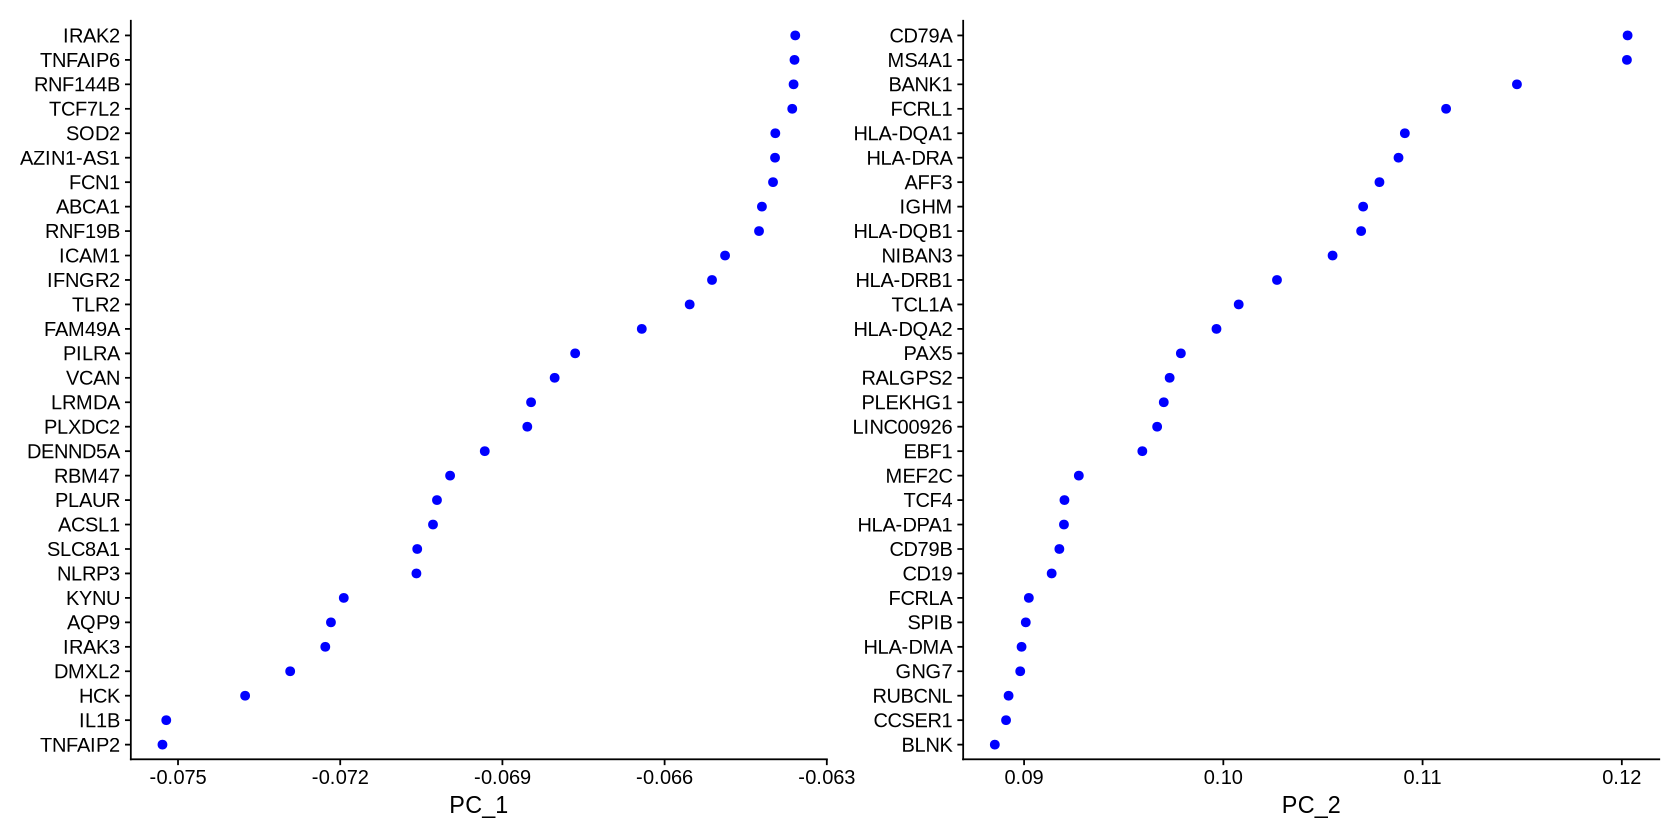

In [11]:
print(pbmc[["pca"]], dims = 1:5, nfeatures = 5)
VizDimLoadings(pbmc, dims = 1:2, reduction = "pca")

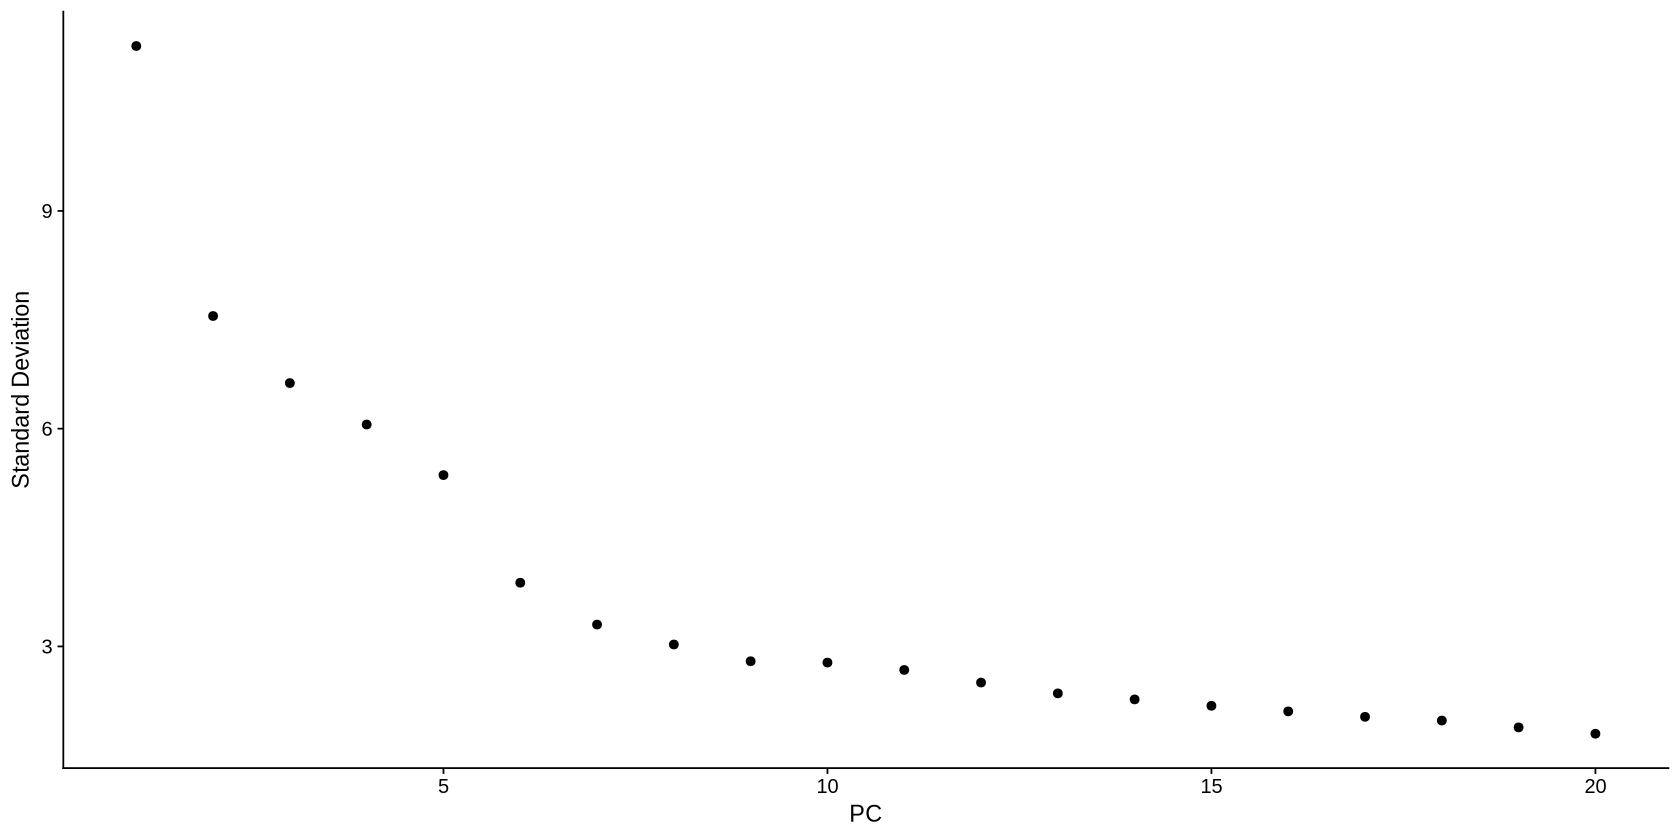

In [12]:
ElbowPlot(pbmc)

*Cколько главных компонент на ваш взгляд стоит взять в дальнейший анализ? Почему?*  
ElbowPlot показывает долю объяснённой дисперсии каждой компонентой. На графике наблюдается излом примерно на 9-10 компоненте. Значит, первые 9-10 компонент отражают основную биологическую вариабельность данных, тогда как последующие компоненты вносят в основном шум

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
22:25:16 UMAP embedding parameters a = 0.9922 b = 1.112

22:25:16 Read 7864 rows and found 10 numeric columns

22:25:16 Using Annoy for neighbor search, n_neighbors = 2

22:25:17 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

22:25:18 Writing NN index file to temp file /scratch/RtmpxYxjKk/file2a59a258bf5d00

22:25:18 Searching Annoy index using 1 thread, search_k = 200

22:25:18 Annoy recall = 100%

22:25:19 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbo

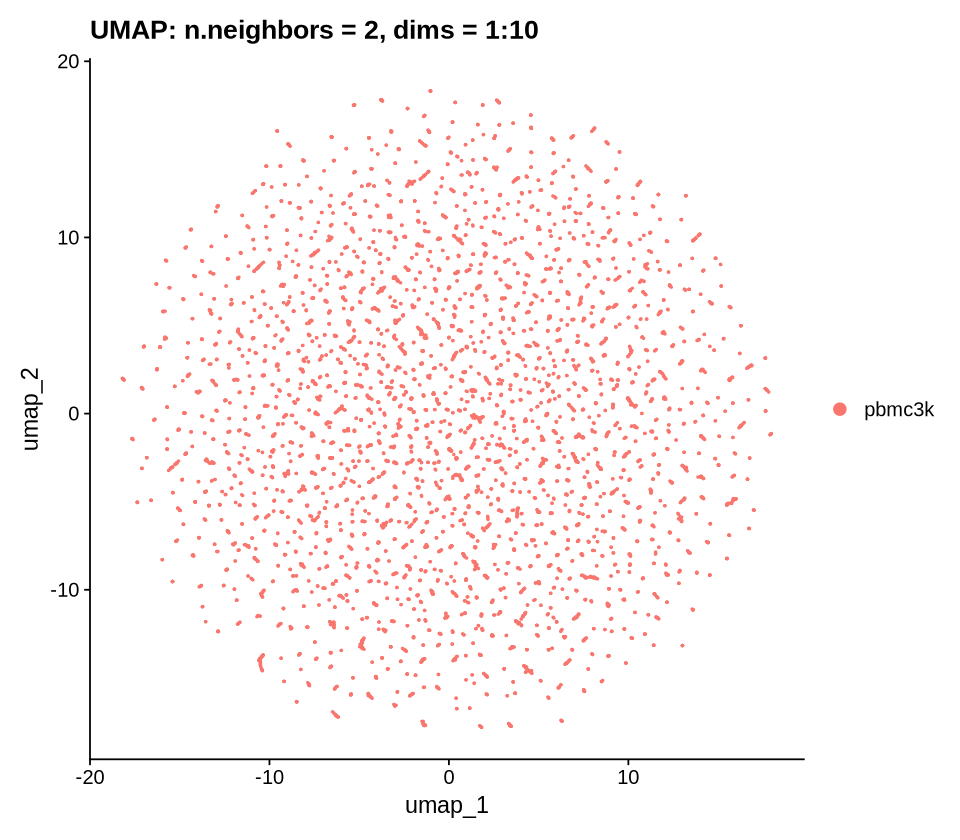

In [13]:
# UMAP с очень маленьким числом соседей
pbmc <- RunUMAP(pbmc, dims = 1:10, n.neighbors = 2)
options(repr.plot.width = 8, repr.plot.height = 7)
DimPlot(pbmc, reduction = "umap") + ggtitle("UMAP: n.neighbors = 2, dims = 1:10")

22:25:23 UMAP embedding parameters a = 0.9922 b = 1.112

22:25:23 Read 7864 rows and found 50 numeric columns

22:25:23 Using Annoy for neighbor search, n_neighbors = 20

22:25:23 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

22:25:24 Writing NN index file to temp file /scratch/RtmpxYxjKk/file2a59a27f9749ec

22:25:24 Searching Annoy index using 1 thread, search_k = 2000

22:25:26 Annoy recall = 100%

22:25:27 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 20

22:25:28 Initializing from normalized Laplacian + noise (using RSpectra)

22:25:28 Commencing optimization for 500 epochs, with 229290 positive edges

22:25:28 Using rng type: pcg

22:25:40 Optimization finished



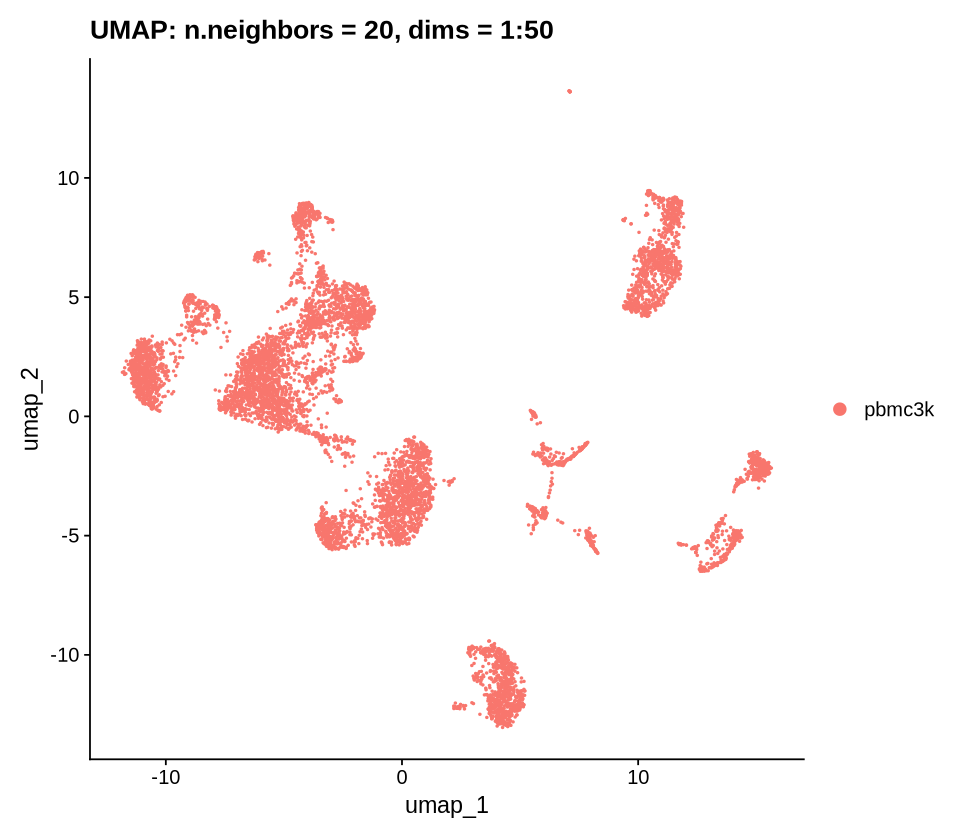

In [14]:
# UMAP с большим числом соседей и большим числом компонент
pbmc <- RunUMAP(pbmc, dims = 1:50, n.neighbors = 20)
options(repr.plot.width = 8, repr.plot.height = 7)
DimPlot(pbmc, reduction = "umap") + ggtitle("UMAP: n.neighbors = 20, dims = 1:50")

22:25:40 UMAP embedding parameters a = 0.9922 b = 1.112

22:25:40 Read 7864 rows and found 10 numeric columns

22:25:40 Using Annoy for neighbor search, n_neighbors = 40

22:25:40 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

22:25:41 Writing NN index file to temp file /scratch/RtmpxYxjKk/file2a59a24f15aa9b

22:25:41 Searching Annoy index using 1 thread, search_k = 4000

22:25:45 Annoy recall = 100%

22:25:45 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 40

22:25:46 Initializing from normalized Laplacian + noise (using RSpectra)

22:25:46 Commencing optimization for 500 epochs, with 429718 positive edges

22:25:46 Using rng type: pcg

22:25:59 Optimization finished



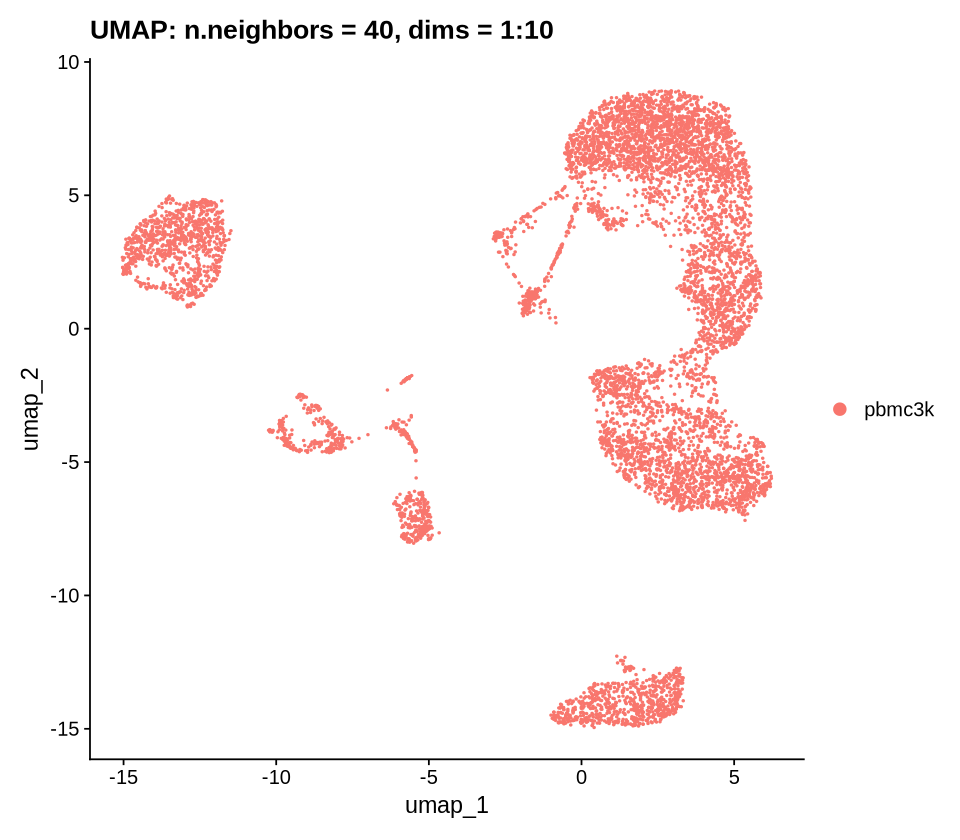

In [15]:
# UMAP с «классическими» параметрами
pbmc <- RunUMAP(pbmc, dims = 1:10, n.neighbors = 40)
options(repr.plot.width = 8, repr.plot.height = 7)
DimPlot(pbmc, reduction = "umap") + ggtitle("UMAP: n.neighbors = 40, dims = 1:10")

*Как думаете, какие могут быть плюсы и минусы у учёта большего/меньшего числа соседей при посторении UMAP и у выбора большего/меньшего числа главных компонент?*  
При малом числе соседей (n.neighbors = 2) кластеры не выделились, что говорит о высокой чувствительность к шуму. При большем числе соседей и большем числе компонент (n.neighbors = 20, dims = 1:50) кластеры выглядят более сглаженными, но часть мелких подгрупп выделяется в отдельные кластеры. Классические параметры (n.neighbors = 40, dims = 1:10) дают сбалансированное представление: кластеры плотные и хорошо разделены

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7864
Number of edges: 251950

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9078
Number of communities: 13
Elapsed time: 0 seconds


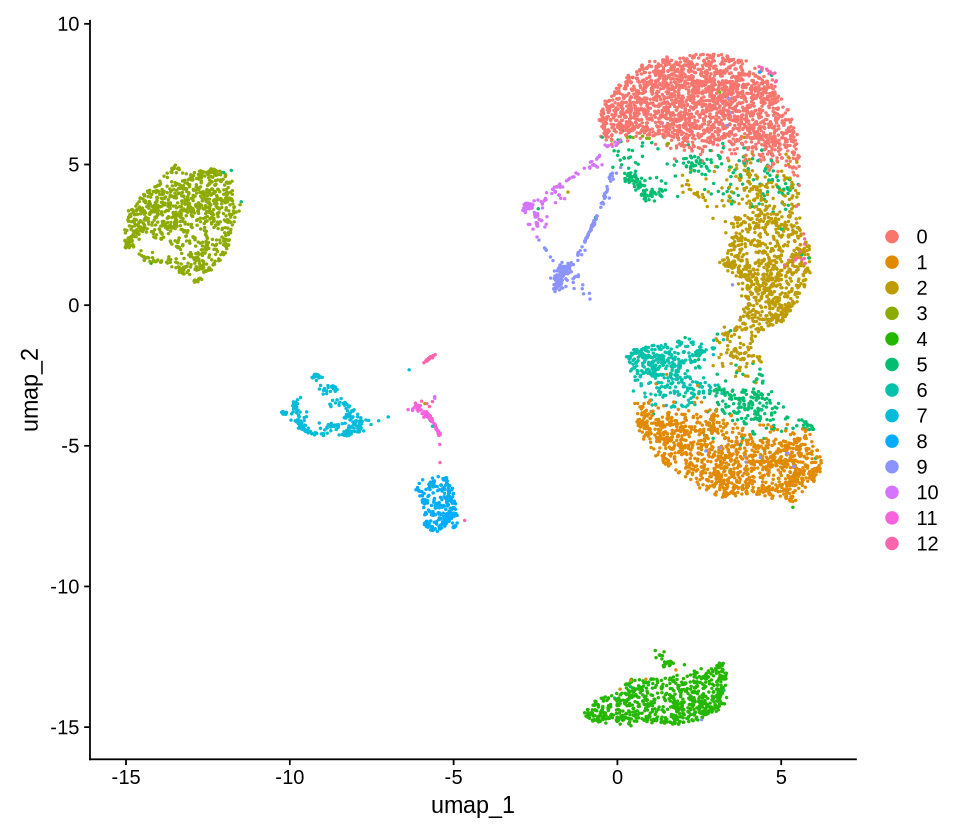

In [16]:
pbmc <- FindNeighbors(pbmc, dims = 1:10)
pbmc <- FindClusters(pbmc, resolution = 0.5)
options(repr.plot.width = 8, repr.plot.height = 7)
DimPlot(pbmc, reduction = "umap")

Проаннотируем клеточные популяции:

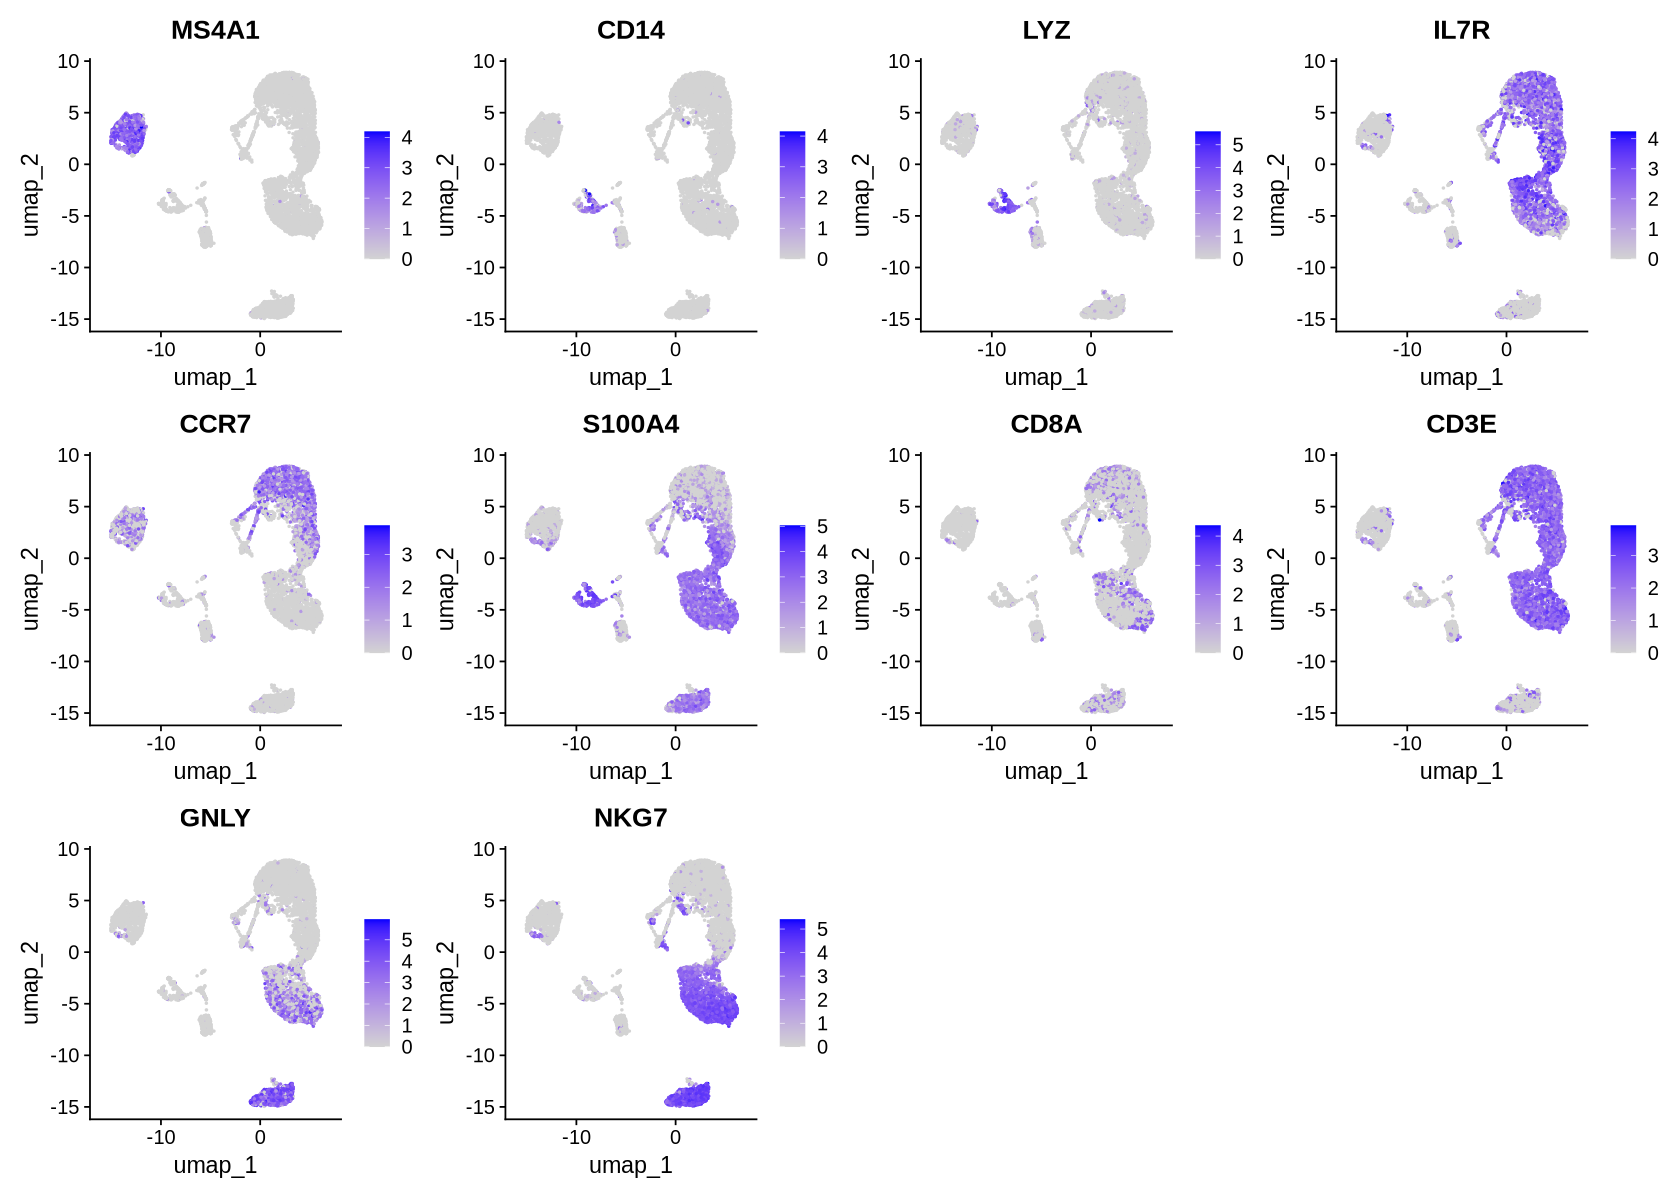

In [25]:
options(repr.plot.width = 14, repr.plot.height = 10)
FeaturePlot(pbmc, features = c("MS4A1", "CD14", "LYZ", "IL7R", "CCR7", "S100A4", "CD8A", "CD3E", "GNLY", "NKG7"))

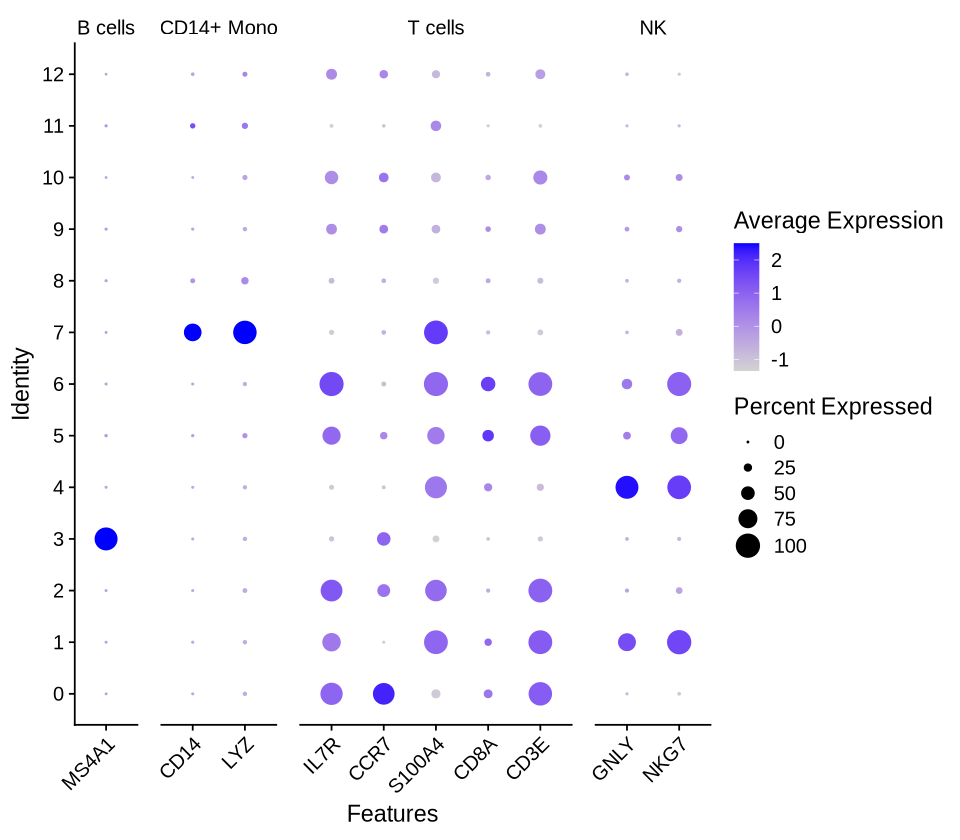

In [21]:
DotPlot(pbmc, features = list(
    "B cells"        = "MS4A1",
    "CD14+ Mono"     = c("CD14", "LYZ"),
    "T cells"   = c("IL7R", "CCR7", "S100A4", "CD8A", "CD3E"),
    "NK"             = c("GNLY", "NKG7")
)) + RotatedAxis()